# Notebook 4.1 - Baseline So Sánh (CNN + Transformer)

Notebook này phục vụ **phần 1 + phần 2** trong kế hoạch:
- Chốt protocol thí nghiệm chung.
- Huấn luyện các baseline trên cùng điều kiện để so sánh công bằng.

In [10]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
repo_root = Path.cwd().resolve()
if not (repo_root / 'src').exists():
    repo_root = repo_root.parent

sys.path.append(str(repo_root))

from src.baseline_experiment import TrainConfig, run_baseline_suite

data_dir = repo_root / 'data' / 'features' / 'mel'
output_dir = repo_root / 'data' / 'models' / 'baselines'

print(f'Repo root: {repo_root}')
print(f'Data dir: {data_dir}')
print(f'Output dir: {output_dir}')

Repo root: /home/anhcbt/extend/workspace/convmixer_model
Data dir: /home/anhcbt/extend/workspace/convmixer_model/data/features/mel
Output dir: /home/anhcbt/extend/workspace/convmixer_model/data/models/baselines


## Protocol thí nghiệm (Part 1)

Các model dùng để so sánh trong phiên bản hiện tại:
- `convmixer_256_8`
- `resnet18`
- `ast_tiny`

`mobilenet_v3_small` được loại khỏi bảng so sánh chính.


In [11]:
selected_models = ('convmixer_256_8', 'resnet18', 'ast_tiny')
USE_CACHED_RESULTS = True  # True: không train lại, đọc kết quả đã có

config = TrainConfig(
    data_dir=str(data_dir),
    output_dir=str(output_dir),
    model_names=selected_models,
    seeds=(42,),  # Đổi thành (42, 43, 44, 45, 46) để làm multi-seed
    split_seed=42,
    train_ratio=0.75,
    val_ratio=0.15,
    batch_size=32,
    num_workers=4,
    num_epochs=25,
    lr=1e-3,
    weight_decay=1e-4,
    patience=5,
    min_delta=0.02,
)

config

TrainConfig(data_dir='/home/anhcbt/extend/workspace/convmixer_model/data/features/mel', output_dir='/home/anhcbt/extend/workspace/convmixer_model/data/models/baselines', model_names=('convmixer_256_8', 'resnet18', 'ast_tiny'), seeds=(42,), split_seed=42, train_ratio=0.75, val_ratio=0.15, batch_size=32, num_workers=4, num_epochs=25, lr=0.001, weight_decay=0.0001, patience=5, min_delta=0.02, scheduler_factor=0.2, scheduler_patience=3, scheduler_min_lr=1e-06)

In [12]:
if USE_CACHED_RESULTS:
    runs_df = pd.read_csv(output_dir / 'baseline_runs.csv')
    summary_df = pd.read_csv(output_dir / 'baseline_summary.csv')
    history_store = {}
    metadata = {'mode': 'cached', 'runs_csv': str(output_dir / 'baseline_runs.csv'), 'summary_csv': str(output_dir / 'baseline_summary.csv')}
else:
    runs_df, summary_df, history_store, metadata = run_baseline_suite(config)

runs_df = runs_df[runs_df['model'].isin(selected_models)].copy()
summary_df = summary_df[summary_df['model'].isin(selected_models)].copy()

runs_selected_path = output_dir / 'baseline_runs_selected.csv'
summary_selected_path = output_dir / 'baseline_summary_selected.csv'
runs_df.to_csv(runs_selected_path, index=False)
summary_df.to_csv(summary_selected_path, index=False)

print('Metadata:')
print(metadata)
print('Saved:', runs_selected_path)
print('Saved:', summary_selected_path)

Metadata:
{'mode': 'cached', 'runs_csv': '/home/anhcbt/extend/workspace/convmixer_model/data/models/baselines/baseline_runs.csv', 'summary_csv': '/home/anhcbt/extend/workspace/convmixer_model/data/models/baselines/baseline_summary.csv'}
Saved: /home/anhcbt/extend/workspace/convmixer_model/data/models/baselines/baseline_runs_selected.csv
Saved: /home/anhcbt/extend/workspace/convmixer_model/data/models/baselines/baseline_summary_selected.csv


In [13]:
display_cols = [
    'model', 'seed', 'params', 'best_epoch', 'test_accuracy',
    'macro_f1', 'weighted_f1', 'train_seconds', 'infer_seconds'
]

runs_df[display_cols].sort_values(['test_accuracy', 'macro_f1'], ascending=False)

,model,seed,params,best_epoch,test_accuracy,macro_f1,weighted_f1,train_seconds,infer_seconds
0,convmixer_256_8,42,719117,22,97.938144,0.979560,0.979329,146.239762,0.193548
1,resnet18,42,11174349,22,95.360825,0.953129,0.952992,3351.113757,2.487735
3,ast_tiny,42,1807501,25,59.278351,0.568933,0.572758,205.526299,0.331394


In [14]:
summary_df.sort_values('test_accuracy_mean', ascending=False)

,model,params,test_accuracy_mean,test_accuracy_std,macro_f1_mean,macro_f1_std,weighted_f1_mean,weighted_f1_std,train_seconds_mean,infer_seconds_mean
1,convmixer_256_8,719117.0,97.938144,0.0,0.979560,0.0,0.979329,0.0,146.239762,0.193548
3,resnet18,11174349.0,95.360825,0.0,0.953129,0.0,0.952992,0.0,3351.113757,2.487735
0,ast_tiny,1807501.0,59.278351,0.0,0.568933,0.0,0.572758,0.0,205.526299,0.331394


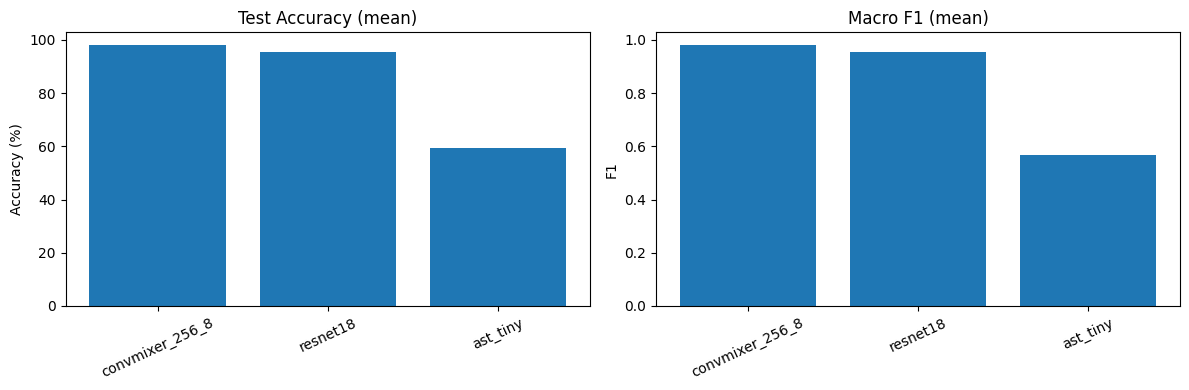

Saved plot: /home/anhcbt/extend/workspace/convmixer_model/data/models/baselines/baseline_compare_selected.png


In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

summary_sorted = summary_df.sort_values('test_accuracy_mean', ascending=False)
ax[0].bar(summary_sorted['model'], summary_sorted['test_accuracy_mean'])
ax[0].set_title('Test Accuracy (mean)')
ax[0].set_ylabel('Accuracy (%)')
ax[0].tick_params(axis='x', rotation=25)

ax[1].bar(summary_sorted['model'], summary_sorted['macro_f1_mean'])
ax[1].set_title('Macro F1 (mean)')
ax[1].set_ylabel('F1')
ax[1].tick_params(axis='x', rotation=25)

plt.tight_layout()
plot_path = output_dir / 'baseline_compare_selected.png'
plt.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.show()
print('Saved plot:', plot_path)

## Gợi ý bước tiếp theo

- Notebook này đã hỗ trợ chế độ `USE_CACHED_RESULTS=True` để vẽ lại biểu đồ mà không train lại.
- Kết quả lọc 3 model được lưu tại:
  - `data/models/baselines/baseline_runs_selected.csv`
  - `data/models/baselines/baseline_summary_selected.csv`
  - `data/models/baselines/baseline_compare_selected.png`
